# Training: Sequence to Sequence Model - Word Classification
Training sequence to sequnce model for recognition of words.
## TODO
```
REMOVE embeddings
Overlaping sliders
One-shot preprocessing
Train preprocessing with RNN
lower extra steps, bigger hState, preprocessing?
```

In [1]:
import sys
import numpy as np
import pandas as pd
import cv2
import matplotlib as plt
import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.layers import core as layers_core
import time
import math
import unidecode

sys.path.append('src')
from ocr.datahelpers import load_words_data, corresponding_shuffle, char2idx
from ocr.helpers import img_extend
from ocr.mlhelpers import TrainingPlot
from ocr.tfhelpers import create_cell
from ocr.imgtransform import coordinates_remap

%matplotlib notebook
plt.rcParams['figure.figsize'] = (9.0, 5.0)

Instructions for updating:
Use the retry module or similar alternatives.


### Loading images

In [2]:
LANG = 'en'

In [3]:
images, labels = load_words_data(
    ['data/processed/breta/words_gaplines/'], load_gaplines=False)

Loading words...
 |████████████████████████████████████████| 100.0% 
-> Number of words: 5069


## Settings

In [4]:
char_size = 82 if LANG =='cz' else 52

PAD = 0   # Padding
EOS = 1   # End of seq

num_new_images = 2                 #  Number of new images per image
fac_alpha = 2.0                    # Factors for image preprocessing
fac_sigma = 0.08

num_buckets = 5
slider_size = (60, 2)
N_INPUT = 60*2                     # Size of sequence input vector
vocab_size = char_size + 2         # Number of different chars + <PAD> and <EOS>
input_embedding_size = vocab_size  # Size of vector for embedding chars2vec


encoder_layers = 2
decoder_layers = 2*encoder_layers  # 2* is due to the bidirectional encoder
encoder_residual_layers = 1        # HAVE TO be smaller than encoder_layers
decoder_residual_layers = 2*encoder_residual_layers
encoder_units = 256
decoder_units = encoder_units

add_output_length = 4 # 4

learning_rate = 1e-4               # 1e-4
max_gradient_norm = 5.0            # For gradient clipping
dropout = 0.4
train_per = 0.8                    # Percentage of training data

TRAIN_STEPS = 100000               # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 2000                       # Number of batches in epoch - not accurate

save_location = 'models/word-clas/' + LANG + '/WordClassifier2'

## Dataset

In [5]:
# Shuffle data for later splitting
images, labels = corresponding_shuffle([images, labels])

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [char2idx(c, True) for c in label]
    
# Split data on train and test dataset
div = int(train_per * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainLabels_idx = labels_idx[0:div]
testLabels_idx = labels_idx[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 4055
Testing images: 1014


### Dataset extending

In [6]:
# Dont mix train and test images
trainImagesFinal = np.empty(len(trainImages) * (num_new_images+1), dtype=object)
trainLabelsFinal_idx = np.empty(len(trainImages)*(num_new_images+1), dtype=object)
for idx, img in enumerate(trainImages):
    trainImagesFinal[idx*(num_new_images+1)] = img
    trainLabelsFinal_idx[idx*(num_new_images+1)] = trainLabels_idx[idx]
    for i in range(num_new_images):
        trainImagesFinal[idx*(num_new_images+1) + (i+1)] = coordinates_remap(img, fac_alpha, fac_sigma)
        trainLabelsFinal_idx[idx*(num_new_images+1) + (i+1)] = trainLabels_idx[idx]
        
print("Transformed train images", len(trainImagesFinal))

Transformed train images 12165


In [7]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 targets,
                 num_buckets=5,
                 slider=(60, 30),
                 train=True):
        
        self.train = train
        
        # First PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        self.slider = slider
        for i in range(len(images)):
            images[i] = img_extend(
                images[i],
                (images[i].shape[0], -(-images[i].shape[1] // slider[1]) * slider[1]))
        in_length = [image.shape[1]//slider[1] for image in images]
        
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [img[:, loc * slider[1]: (loc+1) * slider[1]].flatten()
                         for loc in range(in_length[i])]

        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'out_length': [len(t) for t in targets],
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        input_max = max(res['in_length'])
        output_max = max(res['out_length'])
        # In order to make it work at production
        assert np.all(res['in_length'] + add_output_length >= res['out_length'])
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the maximum length output sequence
        targets = np.zeros([batch_size, output_max], dtype=np.int32)
        for i, target in enumerate(targets):
            target[:res['out_length'].values[i]] = res['targets'].values[i]
        targets = targets.swapaxes(0, 1)
        
        return input_seq, targets, res['in_length'].values, res['out_length'].values
    
    def next_feed(self, size):
        """ Create feed directly for model training """
        (encoder_inputs_,
         decoder_targets_,
         encoder_inputs_length_,
         decoder_targets_length_) = self.next_batch(size)
        return {
            encoder_inputs: encoder_inputs_,
            encoder_inputs_length: encoder_inputs_length_,
            decoder_targets: decoder_targets_,
            decoder_targets_length: decoder_targets_length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [8]:
# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
train_iterator = BucketDataIterator(trainImagesFinal,
                                    trainLabelsFinal_idx,
                                    num_buckets,
                                    slider_size,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testLabels_idx,
                                   num_buckets,
                                   slider_size,
                                   train=False)

Iterator created.
Iterator created.


## Placeholders

In [9]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Encoder inputs shape (max_seq_length, batch_size, vec_size)
encoder_inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,),
                                       dtype=tf.int32,
                                       name='encoder_inputs_length')
# required for training, not required for testing and application
decoder_targets = tf.placeholder(shape=(None, None),
                                 dtype=tf.int32,
                                 name='decoder_targets')
decoder_targets_length = tf.placeholder(shape=(None,),
                                        dtype=tf.int32,
                                        name='decoder_targets_length')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Decoder Train Feeds

In [10]:
sequence_size, batch_size = tf.unstack(tf.shape(decoder_targets))

test_length = tf.floor_div(tf.reduce_max(encoder_inputs_length), 7) + add_output_length

EOS_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * EOS
PAD_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * PAD

# Train inputs with EOS symbol at start of seq
decoder_train_inputs = tf.concat([EOS_SLICE, decoder_targets], axis=0)
decoder_train_length = decoder_targets_length + 1

# train targets with EOS symbol at end of seq
decoder_train_targets = tf.concat([decoder_targets, PAD_SLICE], axis=0)
decoder_train_targets_seq_len, _ = tf.unstack(tf.shape(decoder_train_targets))
decoder_train_targets_eos_mask = tf.one_hot(decoder_train_length - 1,
                                            decoder_train_targets_seq_len,
                                            on_value=EOS, off_value=PAD,
                                            dtype=tf.int32)
decoder_train_targets_eos_mask = tf.transpose(decoder_train_targets_eos_mask, [1, 0])

# hacky way using one_hot to put EOS symbol at the end of target sequence
decoder_train_targets = tf.add(decoder_train_targets,
                               decoder_train_targets_eos_mask)

# Pad test accuracy
decoder_test_targets = tf.pad(
    decoder_train_targets,
    [[0, test_length - decoder_train_targets_seq_len], [0, 0]],
    mode='CONSTANT')

loss_weights = tf.sequence_mask(
    decoder_train_length,
    tf.reduce_max(decoder_train_length),
    dtype=tf.float32)

test_weights = tf.sequence_mask(
    decoder_train_length,
    test_length,
    dtype=tf.float32)

### Embeddings

In [11]:
# Randomly initialized embedding matrix, for characters embedding in decoder
embeddings = tf.Variable(tf.random_uniform([vocab_size,
                                            input_embedding_size],
                                           -1.0, 1.0), dtype=tf.float32)

decoder_train_inputs_embedded = tf.nn.embedding_lookup(
    embeddings, decoder_train_inputs)

## Encoder

In [12]:
enc_cell_fw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)
enc_cell_bw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)

In [13]:
# Help functions for standard layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# 1. Layer - Convulation variables
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 4],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[4]), name='b_conv1')
# 3. Layer - Convulation variables
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 4, 8],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[8]), name='b_conv2')

def CNN(x):
    x = tf.image.per_image_standardization(x)
    x_img = tf.reshape(x, [1, slider_size[0], slider_size[1], 1])
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d(x_img, W_conv1) + b_conv1, name='h_conv1')
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Layer - Convulation
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
    # 4. Layer - Max Pool
    return max_pool_2x2(h_conv2, name='h_pool2')

# Input images CNN
inputs = tf.map_fn(
    lambda seq: tf.map_fn(
        lambda img:
            tf.reshape(
                CNN(tf.reshape(img, [slider_size[0], slider_size[1], 1])), [-1]),
        seq),
    encoder_inputs,
    dtype=tf.float32)

# Bidirectional RNN, gibe fw and bw outputs separately
enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = enc_cell_fw,
    cell_bw = enc_cell_bw,
    inputs = inputs,
    sequence_length = encoder_inputs_length,
    dtype = tf.float32,
    time_major = True)

encoder_outputs = tf.concat(enc_outputs, -1)

if encoder_layers == 1:
    encoder_state = enc_state
else:
    encoder_state = []
    for layer_id in range(encoder_layers):
        encoder_state.append(enc_state[0][layer_id])  # forward
        encoder_state.append(enc_state[1][layer_id])  # backward
    encoder_state = tuple(encoder_state)

## Decoder

In [14]:
# attention_states: size [batch_size, max_time, num_units]
attention_states = tf.transpose(encoder_outputs, [1, 0, 2])

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    decoder_units, attention_states,
    memory_sequence_length=encoder_inputs_length)


decoder_cell = create_cell(decoder_units,
                           decoder_layers,
                           decoder_residual_layers,
                           is_dropout=True,
                           keep_prob=keep_prob)

decoder_cell = seq2seq.AttentionWrapper(
    decoder_cell, attention_mechanism,
    attention_layer_size=decoder_units)

decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(
    cell_state=encoder_state)

### TRAIN DECODER ###
# Helper
helper = seq2seq.TrainingHelper(
    decoder_train_inputs_embedded, decoder_train_length, time_major=True)

# Decoder
projection_layer = layers_core.Dense(
    vocab_size, use_bias=False)

decoder = seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
# outputs.rnn_output   = plain output
# outputs.sample_id = tf.argmax(outputs.rnn_output, axis=-1)
outputs, final_context_state, _ = seq2seq.dynamic_decode(
    decoder)

logits_train = outputs.rnn_output
prediction_train = outputs.sample_id


### INFERENCE DECODER ###
# Helper
helper_infer = seq2seq.GreedyEmbeddingHelper(
    embeddings,
    tf.fill([batch_size], EOS), EOS)

# Decoder
decoder_infer = seq2seq.BasicDecoder(
    decoder_cell, helper_infer, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
outputs_infer, final_context_state, final_seq_lengths = seq2seq.dynamic_decode(
    decoder_infer,
    impute_finished=True,
#     maximum_iterations=tf.reduce_max(encoder_inputs_length) + add_output_length)
    maximum_iterations=test_length)
prediction_inference = tf.identity(outputs_infer.sample_id,
                                   name='prediction_infer')

### Optimizer

In [15]:
targets = tf.transpose(decoder_train_targets, [1, 0])
test_targets = tf.transpose(decoder_test_targets, [1, 0])
## Loss
loss = seq2seq.sequence_loss(logits=logits_train,
                             targets=targets,
                             weights=loss_weights,
                             name='loss')

## Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

### Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.apply_gradients(
    zip(clipped_gradients, params),
    name='train_step')


### Evaluate model
# Pad prediction to match lengths
prediction_infer_padded = tf.pad(
    prediction_inference,
    [[0, 0], [0, test_length - tf.reduce_max(final_seq_lengths)]],
    mode='CONSTANT')

correct_prediction = tf.equal(prediction_infer_padded,
                              test_targets)
## Advanced accuracy only the elements of seq including EOS symbol
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.float32)*test_weights)/tf.reduce_sum(test_weights)

## Training

batch 0 - loss: 3.9814613
    expected  > [43 42 30 36 47 28 30  1  0  0  0  0  0  0  0]
    predicted > [42 42 42 42 42 42 42 42 42 42 42  9  9 26 26]
    expected  > [ 3 48 40  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [ 9  9  9  9 26 26 26 26 26 26 26 26 16 16 16]

batch 2000 - loss: 1.8423418
    expected  > [41 32 37 39 32 43 46 36  1  0  0  0  0  0  0]
    predicted > [46 32 37 39 32 49 32  1  0  0  0  0  0  0  0]
    expected  > [52 32 39 39 42 50  1  0  0  0  0  0  0  0  0]
    predicted > [42 39 42 49  1  0  0  0  0  0  0  0  0  0  0]

Training interrupted, model saved.


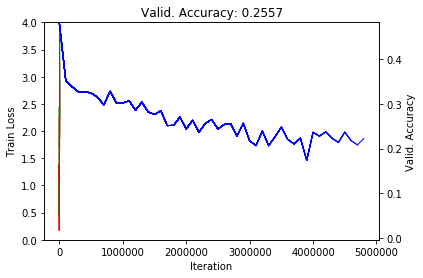

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.update_loss(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.update_acc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_location)
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_, target_ = sess.run([prediction_infer_padded, test_targets], fd_test)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 1:
                    break
            print()

except KeyboardInterrupt:
    saver.save(sess, save_location)
    print('Training interrupted, model saved.')

In [17]:
for i in range(5):
    fd_test = test_iterator.next_feed(BATCH_SIZE)
    predict_, target_ = sess.run([prediction_infer_padded, test_targets], fd_test)
    for i, (inp, pred) in enumerate(zip(target_, predict_)):
        print('    expected  > {}'.format(inp))
        print('    predicted > {}'.format(pred))
        if i >= 1:
            break
    print()

    expected  > [ 7 48 41 41 52  1  0  0  0  0  0]
    predicted > [20 42 40 42 45 52  1  0  0  0  0]
    expected  > [39 36 38 32 39 52  1  0  0  0  0]
    predicted > [47 36 39 52  1  0  0  0  0  0  0]

    expected  > [50 28 36 47  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [50 32 41 32 39  1  0  0  0  0  0  0  0  0  0]
    expected  > [20 28 31 45 28  1  0  0  0  0  0  0  0  0  0]
    predicted > [17 28 38 28  1  0  0  0  0  0  0  0  0  0  0]

    expected  > [47 36 53  1  0  0  0  0  0  0  0]
    predicted > [47 36 38  1  0  0  0  0  0  0  0]
    expected  > [40 39 28 31 52  1  0  0  0  0  0]
    predicted > [41 32 38 52  1  0  0  0  0  0  0]

    expected  > [34 28 53 36 41 34  1  0  0  0  0  0  0]
    predicted > [43 45 28 41 32  1  0  0  0  0  0  0  0]
    expected  > [35 42 40 32  1  0  0  0  0  0  0  0  0]
    predicted > [47 42 41 32  1  0  0  0  0  0  0  0  0]

    expected  > [34  1  0  0  0  0  0  0  0]
    predicted > [26  1  0  0  0  0  0  0  0]
    expected  > [3